In [1]:
import torch, time, pickle,os
import torch_geometric as tg
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp
import networkx as nx

In [2]:
def convert(d,p):
    dfin=[]
    if len(p)!=len(np.unique(p)):
        print('Wrong order of prog/desc')
    else:
        no=d[0]
        for desc in d:
            if desc==no:
                dfin.append(0)
            else:
                dfin.append(p.index(desc)+1)
    return dfin, np.arange(1, 1+len(p))

In [3]:
#should it be log for output
def graphs_beforeafter(tcols=[0,2,4,5,6,7,8,10,22], target=8, save=False, lim=10.5, case='test', transform='quantile', maxs=[1,1,1]):
    ##all the requirements
    dat=[]
    tcols=np.array(tcols)
    raw_path='~/../../../tigress/mcranmer/merger_trees/isotrees/'
    target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
    transform_path=f'../../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
    scaler=pickle.load(open(transform_path, 'rb'))
    not_include=np.array([0,1,0,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0])  ##needs update
    is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]
    is_cat=np.array([bool(i) for i in is_cat])
    icols=np.array([1,3]) #index columns
    load_cols=np.sort(np.concatenate([tcols,icols]))
    not_include=not_include[load_cols] 
    print(f'Loading {maxs[0]*maxs[1]*maxs[2]} isotrees')
    for i in range(0, maxs[0]):
            for j in range(0,maxs[1]):
                for k in range(0, maxs[2]):
                    ###Start loading
                    start=time.time()
                    print(f'Loading isotree {i}_{j}_{k}')

                    pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
                    print(f'isotree {i}_{j}_{k} loaded, restructuring')

                    raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
                    del pd1

                    trees=raw[raw.isna()['desc_id(3)']] 
                    halos=raw[~raw.isna()['desc_id(3)']]
                    del raw
                    
                    ##########################################
                    ### End loading, begin dtype changing  ###
                    ##########################################
                    
                    mask=halos.dtypes.values[1:]=='O'

                    f,it="float64", "int64"
                    map1=[]
                    map2=[]
                    q=0
                    for l in load_cols:
                        q+=1
                        if l<25:
                            map1.append(l)
                            map2.append(q)
                    map1=np.array(map1)
                    map2=np.array(map2)

                    castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

                    castto=castto[map1]
                    dicts = {}
                    keys = halos.columns[map2]
                    for d, key in enumerate(keys):
                            dicts[key] = castto[d]

                    halos=halos.astype(dicts)
                    
                    ###################################################
                    ### end dtype, begin inital hardcoded scaling   ###
                    ###################################################
                    
                    hard=[0,2,15]
                    def logit(x):
                        return np.log10((x+0.001)/(1.01-x))
                    ##logit transform the hards
                    for h in hard:
                        if h in tcols:
                            h1=np.where(load_cols==h)[0][0]+1
                            halos[halos.columns[h1]]=logit(halos[halos.columns[h1]])

                    log=[10,38, 39, 40, 41, 42]

                    def logt(x):
                        return np.log10(x+1)
                    for l in log:
                        if l in tcols:
                            l1=np.where(load_cols==l)[0][0]+1
                            halos[halos.columns[l1]]=logt(halos[halos.columns[l1]])
                    
                    ###################################################
                    ### Begin scaling and splitting to trees.       ###
                    ###################################################

                    scale_cols=np.array(tcols[~is_cat[tcols]])
                    
                    print(f'Splitting to tree and scaling')
                    spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
                    splits=[]
                    for s in spli:
                        if s[0,np.where(load_cols==10)[0][0]]>lim:
                            splits.append(s)
                    splits=np.array(splits, dtype=object)
                    split=[]
                    idx=[]
                    for m, tree in enumerate(splits):
                        s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
                        if len(s)>20000:
                            print(len(s))
                        else:
                            for n in scale_cols:
                                n1=np.where(load_cols==n)[0][0]
                                s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1]))

                            split.append(s)
                            idx.append(m)
                    split=np.array(split, dtype=object)
                    print('Split done')

                    halwgal=split
                    hraw=np.array(splits[idx], dtype=object)
                    
                    ###################################################
                    ### Making the actual merger tree       ###
                    ###################################################
                    
                    hals=[]
                    out=[]
                    pr,de=[],[]
                    discards=[]
                    print('Making merger tree')
                    for n in tqdm(range(len(halwgal))):
                        h=halwgal[n]
                        roots=h[h[:,4]==0]
                        mergers=h[h[:,4]>1]
                        final=h[h[:,3]==-1]
                        pro, des=[],[]
                        discarded=[]
                        for mid in mergers[:,1]:
                            k=1 ## counts number of contracted edges
                            ##descendant ID of raw where the id of the merger is
                            descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])]
                            while descid not in mergers[:,1] and descid!=-1: 
                                k+=1
                                descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
                            pro.append(mid)
                            if descid!=-1:
                                des.append(descid[0])
                            else:
                                des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
                            discarded.append(1/k) ## adding 1/k so it stays bounded

                        for r in roots:
                            descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
                            k=1
                            while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
                                k+=1
                                descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
                            pro.append(r[1])
                            if descid!=-1:
                                des.append(descid[0])
                            else:
                                des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
                            discarded.append(1/k) 
                        discards.append(np.array(discarded))
                        des,pro=convert(des, pro)
                        hal2=np.vstack([final,mergers,roots])
                        if n==0:
                            ##choose columns to carry forward
                            fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] 
                            mask=np.array([bool(i) for i in not_include])
                            idcols=load_cols[~mask]
                            mass_id=np.where(np.array(idcols)==10)[0][0]
                            fcols=np.array(fcols)
                        hal2=hal2[:,fcols] ##take away id's and such
                        hals.append(hal2)
                        froms=[int(p) for p in pro]
                        tos=[int(d) for d in des]
                        pr.append(froms)
                        de.append(tos)
                        av=0
                        for n in np.unique(tos):
                            m_f=hal2[n, mass_id]
                            m_in=hal2[np.array(froms)[np.where(tos==n)], mass_id]
                            av+=abs(m_f - np.sum(m_in))
                    #     avs.append(av) 
                        out.append(np.log10(av)) ## should log be right???
                    hals=np.array(hals,dtype=object)
                    out=np.array(out)
                    for n in tqdm(range(len(out))):
                        edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
                        x = torch.tensor(hals[n], dtype=torch.float)

                        y=torch.tensor(out[n], dtype=torch.float)
                        edge_attr=torch.tensor(discards[n], dtype=torch.float)
                        graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
                        dat.append(graph)
                    stop=time.time()
                    print(f'Done with tree. \n Time elapsed {stop-start} s')
    datm, dats, datb=[], [], []
    for d in dat:
        if len(d.x.numpy())<30:
            dats.append(d)
        elif len(d.x.numpy())>250:
            datb.append(d)
        else:
            datm.append(d)
    sizes=[dats, datm, datb]
    if save:
        print("Saving dataset")
        if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
            os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

        with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
            pickle.dump(dat, handle)

            strs=['small','medium', 'big']
            for siz, sts in zip(sizes, strs):
                with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data_{sts}.pkl', 'wb') as handle:
                    pickle.dump(np.array(siz), handle)
    return dat, sizes


In [4]:
all_cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
# all_cols=np.array([0,2,4,6,7,8,10,11,12,13,14,15,16,17,18,19,22,23,25,35]+list(range(37,60)))

dat, sizes=graphs_beforeafter(tcols=all_cols, maxs=[1,3,3], lim=10, save=1, case='medium_beforeafter')

Loading 9  isotrees
Loading isotree 0_0_0


/tmp/ipykernel_27989/3461313226.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graphs_beforeafter(tcols=all_cols, maxs=[1,3,3], lim=10, save=1, case='medium_beforeafter')


isotree 0_0_0 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|██████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 14982.99it/s]


Done with tree. 
 Time elapsed 141.63116025924683 s
Loading isotree 0_0_1


/tmp/ipykernel_27989/3461313226.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graphs_beforeafter(tcols=all_cols, maxs=[1,3,3], lim=10, save=1, case='medium_beforeafter')


isotree 0_0_1 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|████████████████████████████████████████████████████████| 1339/1339 [00:00<00:00, 11212.79it/s]


Done with tree. 
 Time elapsed 418.4934730529785 s
Loading isotree 0_0_2


/tmp/ipykernel_27989/3461313226.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graphs_beforeafter(tcols=all_cols, maxs=[1,3,3], lim=10, save=1, case='medium_beforeafter')


isotree 0_0_2 loaded, restructuring
Splitting to tree and scaling
72404
60368
26084
29167
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1474/1474 [00:00<00:00, 6727.98it/s]


Done with tree. 
 Time elapsed 404.4072370529175 s
Loading isotree 0_1_0


/tmp/ipykernel_27989/3461313226.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graphs_beforeafter(tcols=all_cols, maxs=[1,3,3], lim=10, save=1, case='medium_beforeafter')


isotree 0_1_0 loaded, restructuring
Splitting to tree and scaling
70472
Split done
Making merger tree


100%|████████████████████████████████████████████████████████| 1129/1129 [00:00<00:00, 10952.20it/s]


Done with tree. 
 Time elapsed 317.5025222301483 s
Loading isotree 0_1_1


/tmp/ipykernel_27989/3461313226.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graphs_beforeafter(tcols=all_cols, maxs=[1,3,3], lim=10, save=1, case='medium_beforeafter')


isotree 0_1_1 loaded, restructuring
Splitting to tree and scaling
70115
52207
43321
25280
381538
Split done
Making merger tree


100%|████████████████████████████████████████████████████████| 1935/1935 [00:00<00:00, 11421.50it/s]


Done with tree. 
 Time elapsed 499.8832767009735 s
Loading isotree 0_1_2


/tmp/ipykernel_27989/3461313226.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graphs_beforeafter(tcols=all_cols, maxs=[1,3,3], lim=10, save=1, case='medium_beforeafter')


isotree 0_1_2 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|██████████████████████████████████████████████████████████| 605/605 [00:00<00:00, 16778.10it/s]


Done with tree. 
 Time elapsed 97.28754878044128 s
Loading isotree 0_2_0


/tmp/ipykernel_27989/3461313226.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graphs_beforeafter(tcols=all_cols, maxs=[1,3,3], lim=10, save=1, case='medium_beforeafter')


isotree 0_2_0 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|████████████████████████████████████████████████████████| 1176/1176 [00:00<00:00, 11053.92it/s]


Done with tree. 
 Time elapsed 366.96021485328674 s
Loading isotree 0_2_1


/tmp/ipykernel_27989/3461313226.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graphs_beforeafter(tcols=all_cols, maxs=[1,3,3], lim=10, save=1, case='medium_beforeafter')


isotree 0_2_1 loaded, restructuring
Splitting to tree and scaling
50415
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1289/1289 [00:00<00:00, 5587.89it/s]


Done with tree. 
 Time elapsed 371.21220421791077 s
Loading isotree 0_2_2


/tmp/ipykernel_27989/3461313226.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graphs_beforeafter(tcols=all_cols, maxs=[1,3,3], lim=10, save=1, case='medium_beforeafter')


isotree 0_2_2 loaded, restructuring
Splitting to tree and scaling
43429
Split done
Making merger tree


100%|██████████████████████████████████████████████████████████| 807/807 [00:00<00:00, 13021.73it/s]


Done with tree. 
 Time elapsed 193.21232748031616 s
Saving dataset


/tmp/ipykernel_27989/3866062503.py:213: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pickle.dump(np.array(siz), handle)


### I think this is just due to total amount of nodes

In [5]:
avs=[]
ys=[]
ls=[]
for i in range(len(dat)):
    g=dat[i]
    ys.append(g.y.numpy())
    prog, desc=g.edge_index #from, to
    x=g.x
    av=0
    for n in np.unique(desc):
        m_f=x[n, 3]
        m_in=x[prog[np.where(desc==n)], 3]
    #     print(m_f, m_in, np.sum(m_in.numpy()))
        av+=abs(m_f.numpy() - np.sum(m_in.numpy()))
    ls.append(len(x))
    avs.append(av) 

(array([1.000e+00, 3.790e+02, 4.548e+03, 3.149e+03, 1.379e+03, 6.220e+02,
        2.620e+02, 1.010e+02, 5.000e+01, 3.300e+01]),
 array([0.60205999, 0.97172402, 1.34138805, 1.71105208, 2.08071611,
        2.45038014, 2.82004417, 3.1897082 , 3.55937222, 3.92903625,
        4.29870028]),
 <BarContainer object of 10 artists>)

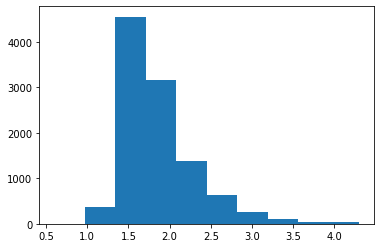

In [6]:
plt.hist(np.log10(ls))

(array([   7.,  307., 3182., 3976., 1764.,  757.,  327.,  119.,   52.,
          33.]),
 array([0.07570525, 0.47523172, 0.8747582 , 1.27428467, 1.67381115,
        2.07333762, 2.4728641 , 2.87239058, 3.27191705, 3.67144353,
        4.07097   ]),
 <BarContainer object of 10 artists>)

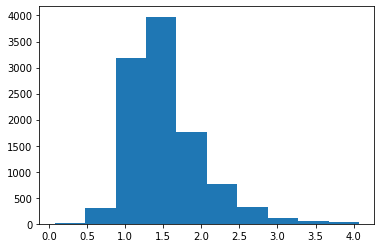

In [7]:
plt.hist(np.log10(avs))

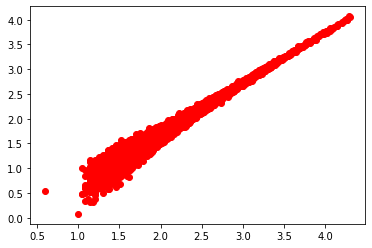

In [8]:
plt.plot(np.log10(ls),np.log10(avs), 'ro')

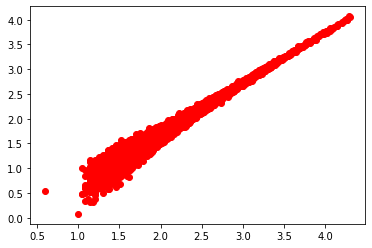

In [9]:
plt.plot(np.log10(ls),ys, 'ro')

### Magnitude due to total amount of nodes, up or down is pretty random

In [42]:
avs=[]
ls=[]
for i in range(len(dat)):
    g=dat[i]
    prog, desc=g.edge_index #from, to
    x=g.x
    av=0
    for n in np.unique(desc):
        m_f=x[n, 3]
        m_in=x[prog[np.where(desc==n)], 3]
    #     print(m_f, m_in, np.sum(m_in.numpy()))
        av+=m_f.numpy() - np.sum(m_in.numpy())
    ls.append(len(x))
    avs.append(av)

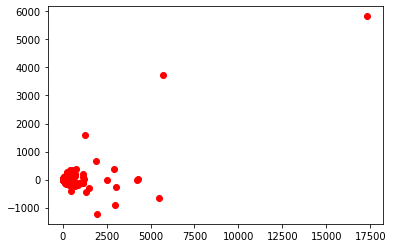

In [45]:
plt.plot(ls,avs, 'ro')

## Make better plotting (make pos, edge_length)

In [ ]:
j=0
from matplotlib import cm
cmap=cm.get_cmap(name='magma')
fig,ax=plt.subplots(figsize=(15,8))
G=tg.utils.to_networkx(dat[j])
di=nx.betweenness_centrality(G)
for q,key in enumerate(di.keys()):
    di[key]=dat[j].x.numpy()[q,2]
nx.set_node_attributes(G, di, 'n_prog')
print('Made graph')
# G.remove_nodes_from(list(nx.isolates(G)))
pos=nx.planar_layout(G)
# pos=nx.kamada_kawai_layout(G) #this one is kinda snakey but works pretty well! Slow as hell though
if G.number_of_nodes()<2000:
    print('drawing')
    nx.draw(G, pos=pos,ax=ax, node_size=8, arrowsize=5, cmap=cmap)

In [ ]:
import matplotlib.pyplot as plt
# create number for each group to allow use of colormap
from itertools import count
fig,ax=plt.subplots(figsize=(20,8))
# get unique groups
groups = set(nx.get_node_attributes(G,'n_prog').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors=dat[j].x.numpy()[:,2]
sizes=(dat[j].x.numpy()[:,3]-min(dat[j].x.numpy()[:,3])+2)**2/10
# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.planar_layout(G)
pos[min(pos.keys())]=(pos[min(pos.keys())]*np.array([-0.75,1.1]))*1.1
# pos[max(pos.keys())]=pos[max(pos.keys())]*np.array([0.9,-0.9])
ec = nx.draw_networkx_edges(G, pos,arrowsize=10, ax=ax, alpha=0.4)
nc = nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=nodes, node_color=colors, node_size=sizes, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()